## ST446 Research Project Report

# *Implementation of the Robust Random Cut Forest algorithm for Online Anomaly Detection over Streaming Data*

## 0. Project Overview

The project examines how to develop an Online Anomaly Detection framework over streams. The project goal was to implement the Robust Random Cut Forest (RRCF) algorithm on Google Cloud Platform Virtual Machines to handle large amount of multidimensional data streams from scratch. This project also examines how to effectively transform conventional dataframes into Spark RDD such that they would be complementary to the RRCF algorithm.

This research is inspired by the ongoing interest of developing efficient anomaly detection methods on streams in the Data Science community. From detecting credit card frauds to monitoring fuel tank controller signals to prevent costly oil spills, the practical uses of such methods are limitless. As the RRCF alorithm was developed by Amazon Researchers, its fuctionality is, as of 2020, exclusive to Amazon Kinesis and SageMaker users. This research is strongly motivated by the business need of those who have existing data analytics infrastructure on Google Cloud Platform. In this project, the main algorithm from the original paper is followed, with an alteration to the algorithm for estimating the anomaly scores.

<i>This project includes:</i>

- Dataset building for anomaly detection on streams
- Implementing the Robust Random Cut Forest algorithm which includes building individual trees, updating and removing points from the trees and calculating collusive displacement. 
- Training our model on Google Cloud Platform machine and testing it against a simulated test data set.
- Discussions on accuracy, efficiency and thresholding in user specific contexts.

<i>Distributed Computing For Big Data concepts in this project including further research ideas:</i>

- Tree-based machine learning methods with Discretized Stream data type (DStream)

#### 0.1 Summary of Results

We successfully reproduced the Robust Random Cut Forest algorithm on Google Cloud Platform using PySpark for data processing. The final numerical evaluations show that for the simulated dataset injected with anomalous trading volumes managed to achieve the precision and recall metric scores of 0.3 and 0.81.

<img src="figs/gild.png" width = 500>

The RRCF algorithm performed better on detecting anomalous data points when shingling is used. This validates the RRCF as an efficient anomaly detection methodology that is capable of identifying anomalous points in a high-dimensional setting.



|        |          | Predicted |          |
|--------|----------|:---------:|----------|
|        |          | Negative  | Positive |
| **Actual** | Negative | 433       | 21       |
|        | Positive | 2         | 9        |

## 1. Introduction and Research Question

##### 1.1 Application Goals

The application context of the anomaly detection project is Apache Spark, more specifically PySpark on a Google Cloud Platform Virtual Machine. The Goal is to implement the RRCF algorithm that is capable of being ingesting a stream of time-series data that are both large in volume and multidimensional.

##### 1.2 Research Goals / Question

The project entails the devicing and implementing the RRCF algorithm on GCP. This was based on the following research question:

*How to effectively execute an anomaly detection system using the RRCF algorithm that is compatible with Apache Spark in the context of stock prices data streams.*

This was examined in the following experiments:

1. Testing the RRCF algorithm on stock price streams that simulate the scenario of insider trading.

2. Using sliding time windows on the stock prices and trading volumes of the company AIG during 2000-2018 to examine the effectiveness of the RRCF algorithm in capturing known historical events during the period.

##### 1.3 Big Data and Distributed Computing Research Context

There have been an ongoing research on anomaly detection over multidimensional streaming data in recent years. The main challenges are that distributions are assumed on the data and therefore may lead to inaccurate results; algorithms that are unable to handle multimensional streaming data as the inclusion of a new point changes the anomaly score of existing points. Some of the past notable research on anomaly detection include One-class Support Vector Machines (Tax and Duin 2004) which is capable of handling multidimensional data. However due to the requirement of specification of a kernel function along with tuning of hyperparameters, it is rather cumbersome when used. In 2012, a novel approach to anomaly detection is proposed by Liu et al. . The Isolation Forest algorithm isolates anomalies directly without relying on an explicit distance or density metric (Liu et al. 2012). However it is not suitable for streaming data as new points cannot be inserted or deleted from isolation trees once the tree has been constructed. The RRCF algorithm was therefore created in order to overcome these limitations by devicing new insertion and deletion of points in a streaming data context.

## 2. Solution Concepts

Anomaly Detection is defined as finding an observation that diverges from otherwise well-structured or patterned data. The main concept in Isolation-based anomaly detection algorithms is to focus on the property that the anomalous points are sparse in nature, and draws the **attention** away from the normal points. 

<blockquote>...consider Waldo wearing a red fedora in a sea of dark felt hats. While it may be difficult for us to find Waldo in a crowd, if we could forget the faces and see the color ... then the recognition of the anomaly is fairly simple.</blockquote>


#### 2.1 Creation of a Tree

In order to reduce the running time and the memory used, the RRCF algorithms selects randomly the feature choice, which explains the algorithm's suitability and compatibility when dealing with streaming high-dimensional data. Consider the following example with the set of points $S$ and subsequently the bounding box of $[(0,10),(0,30)]$

<img src="figs/cut.gif" width = 500>

The construction of a tree begins with selecting a dimension randomly with probability proportional to the range of the data values on that dimension. For each iteration, the algorithm "optimises" the dimension on which the cut is done. It results in a more efficient algorithm. Then a partition is selected uniformly at random between the minimum and maximum value of that dimension. If the partition isolates a point $x$ from the rest of the point set, a new *leaf node* for $x$ is created, and the point is removed from the point set. The algorithm is applied recursively to each remaining point subsets on both sides of the partition.

<img src="figs/tree_algo.png" width = 500>

#### 2.2 Updating a Random Cut Tree

The main advantage that makes the RRCF algorithm robust in handling streaming data is the ability to update a Tree without processing over all or most of the points in the Tree. This dynamic maintenance of trees allows for efficient identification of anomalies on streaming data and for the model to adapt over time as the input data changes. Anomalies are thus defined as points that substantially change the tree structure upon insertion or deletion.

##### 2.2.1 Algorithm for Deletion of Point

<img src="figs/del_p_algo.png" width = 500>
The deletion operation in a Tree removes a point $x∈S$, thereby producing a tree $T'$ drawn from the distribution RRCF($S-x$). This can be accomplished simply by removing the leaf P corresponding to point $x$, then removing its parent node, and then finally, short-circuiting the sibling of P to the grandparent of P $a$. After deleting, or "forgetting" the point $x$, it is important to update all bounding boxes starting from the new parent upwards.
<img src="figs/disp.png" width = 500>
When we look at the two trees $T(S)$ and $T(S-x)$, we see that all the points in the subtree $c$ have their depth reduced by one in the tree without $x$ while the points in the subtree $b$ have their depth unchanged. The displacement of the point $x$ for this tree will be proportional to the number of points in the subtree $c$.

##### 2.2.2 Algorithm for Insertion of Point

The insertion operation seeks to take a tree T along with a point $p∉S$ and produce a tree $T′$ drawn from RRCF($S∪p$). For each iteration, we generate a new random cut along a random dimension and check whether the cut separates $S$ and $p$. If the cut separates $S$ and $p$, then create a new parent node with $P$ as one child and the subtree T($S$) as the sibling. 
<img src="figs/new_pt.gif" width = 500>
However if the cut does not separate $S$ and $p$, follow the existing cut in the tree which is the one that separates $S$ into $S1$ and $S2$ (e.g. if the dimension value of $p$ is less than the existing cut value then go to the left child, else go to the right child) and then start again from step 1 with the subtree rooted at the new child node. 

<img src="figs/new_pt_2.gif" width = 500>
The pseudocode below shows the insertion algorithm in full detail.
<img src="figs/add_p_algo.png" width = 500>

It is important to reiterate that the above 2 mechanisms made the RRCF algorithm compatibility with Streams Processing:

1. *Data scope* - processing over data within a rolling time window, or on just the most recent data record. In our case, it would be updating the RRCF Trees by inserting new point $p$ and forgeting points $x∈S$ if the capacity of the drawn Trees have been reached.

2. *Data size* - Individual records or micro batches consisting of a few records are ingesting at each pre-defined time point. As the RRCF enables updating the Forest point by point, this algorithm satifies this criteria of Stream Processing.

3. *Low latency* - Stream Processing requires computations that are low in latency in the order of seconds or milliseconds. The use of binary search trees and bit-sized operations enable relatively quick modification to the Forest.

#### 2.3 Displacement and Collusive Displacement

There are 2 notions of measurement of displacement in the original paper. The anomaly score of a point is defined by its **collusive displacement**, which is a measure of change in model complexity incurred by inserting or deleting a given point $x$.
 
##### 2.3.1 Displacement

$$Disp(x, Z) = \sum_{T, y \in Z - {x}} Pr[T] \biggl( f(y, Z, T) - f(y, Z - {x}, T) \biggr)$$

- $Z$:  original set of points
- $Z - {x}$: the original set without point x
- $x$: our point of interest
- $T$ -  a tree in the forest
- $f(y,Z,T(Z))$ : the depth of the point $y$ in the tree $T$ built on $Z$. It is equivalent to its bit depth.

As the RRCT is a binary search tree, the model complexity can thus be represented as the sum of bit depths of all points in the tree. An outlier is thus defined as a point that significantly increases the model complexity when it is included in the tree. We can then define the displacement induced by a point $x$ as **the expected change in the bit depths of all leaves in a RRCT tree** if point $x$ is removed.

When looking at the previous diagram, if we consider that $a$ as the root, $x$ an outlier and $c$ a group of outliers close to $x$, the displacement of the point $x$ will be proportional to the number of points in $c$. 

##### 2.3.2 Collusive Displacement

The original paper extends this notion of displacement by accounting for duplicates and near-duplicates that can mask the presence of outliers. For example, an outlier $p$ is locared far away from the clusters of inliers. If there are other outliers close to $p$, the displacement associated with $p$ will be small as the its removal would cause a small displacement, thus masking the precense of outliers all together. Therefore, *collusive displacement* takes into account of these colluders and remove them alongside $p$. The collusive displacement is then defined as the **expected change in the depth of points in the tree when a point set $C$ containing $x$** is removed:

$$CoDisp(x, Z, |S|) = \underset{S \subseteq Z, T}{\mathbb{E}} \biggl[ \underset{x \in C \subseteq S}{\max} \frac{1}{|C|} \sum_{y \in S - C} \biggl( f(y, S, T) - f(y, S - C, T’’) \biggr) \biggr]$$

- $Z$ : the whole set of points
- $S$ : a subset on which the tree T is built
- $x$ : our point interest 
- $C$ : subset of S containing x
- $f(y,S,T(S))$ : the depth of the point $y$ in the tree $T$ build on $S_z$

In this alogrithm we find the smallest subset of points $C⊇x$ that maximizes the total displacement if all points in $C$ are all removed. The original paper states that $CoDisp$ can be estimated efficiently by considering only “subtrees in the leaf to root path of $x$”. Bartos et at. (2019) propose an algorithm for estimating CoDisp:

1. Start at the leaf of interest and count back to the root the number of leaves in the subtree containing $x$ at each node and the number of leaves in the sibling subtrees. We get $|C|$ and $Disp(C)$
2. Compute ratio $$\frac{Disp(C)}{|C|}$$ The maximum ratio over all nodes in the leaf-to-root path would be an estimate of $CoDisp$ of $x$.

#### 2.4 Streaming Application with Shingling of Data

When the Amazon Researchers are performing anomaly detection  on low dimensional time-series, they noticed it was performing better if a shingle was used. A shingle is essentially a time window that includes the point at $t$ where it represented by a vector of dimension $K$ for a shingle of size $K$. The first component is the value a $t$; the second component is the value at $t-1$ $... ...$ until the last component is the value at $t-(K-1)$. Instead of feeding the RRCF with one-dimensional data, they used a $K$-dimensional data as input in order to capture a typical shape of their data context. Comparing to another Forest-based sketching algorithm the Isolation Forest, the RRCF performs better when the anomalous points are not present in the training dataset. Moreover, when comparing the results on time series, the authors also found that their algorithm better detects the beginning of an anomalous period of time.

When working specfically with Discretized Stream data types, this transformation is easily execueted by the method
```DStream.window(windowLength, slideInterval)```


## 3. Choice and Description of Data

In this project we are going to use the historical U.S. stock prices 1970 - 2018 data set from Kaggle. This particular dataset is chose because of its relatively large volume (1.87GB) and high-dimensionality. In the original paper, the Amazon Researchers tested the RRCF algorithm on a one-dimensional data; we aim to test the algorithm on a dataset with higher dimensions (6-dimensional time series data) in order to fully apprecaite the robustness of the RRCF algorithm. The data set consists of daily (trading days) data on U.S. stocks including open price, close price, adjusted close price, daily low, daily high and trading volume for each stock from the year 1970 to 2018 (48 years in total).

In [1]:
import pandas as pd
df = pd.read_csv('data/historical_stock_prices.csv')
df.head(5)

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [2]:
print(df.shape)

(20973889, 8)


###### 3.1 Data set in use - AIG stock prices

In order to put our algorithm in the context of a financial analyst, a single stock is picked out of all the 6460 U.S. stocks. For investigating the performance of the algorithm, the following dates were manually labeled as anomalies based on knowledge of historical bear markets: period from March 2000 to October 2002 (The bursting of the dot-com bubble and from October 2007 to March 2009 ( bursting of the housing bubble and the collapse of Bear Stearns and Lehman Bros.) 

It must be explained that periods of dates during 2000 to 2010 instead of specific dates are chosen because it is difficult to pinpoint a specific date that this particular stock behaves out of the norm. It requires sophisticated financial analysis beyond the scope of this project to identify and determine empirically whether there is a market anomaly. Therefore, anomalies are manually labelled based on well-known historical events at the beginning of the 21st century that affected the U.S. financial market.


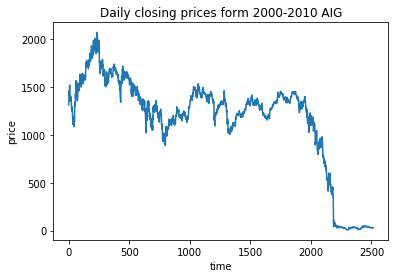

In [3]:
import matplotlib.pyplot as plt
aig = pd.read_csv('data/aig.csv')
plt.plot(aig.iloc[:,2])
plt.title('Daily closing prices form 2000-2010 AIG')
plt.ylabel('price')
plt.xlabel('time')
plt.show()

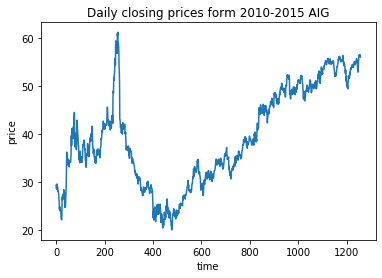

In [4]:
aig_pred = pd.read_csv('data/aig_pred.csv')
plt.plot(aig_pred.iloc[:,2])
plt.title('Daily closing prices form 2010-2015 AIG')
plt.ylabel('price')
plt.xlabel('time')
plt.show()

For model evaluation, we will use a simulated data set. 

###### 3.2 Simulated Data - GILD stock prices

We simulate the scenario of insider trading by injecting anomalies into the daily trading volumes randomly. As an example, Gildead Sciences is picked out of all the 6460 U.S. stocks. For investigating the performance of the algorithm, the following indices were manually labeled as anomalies: 


- ```array([436, 319, 595, 717, 137, 519, 725, 669, 149, 194, 1381, 1360, 1317, 1168, 1366, 1246, 1452, 1247])```

The anomalies are created by taking the mean and standard deviation of the daily trading volumes and generated randomly by fetching Gaussian samples. 

Stock market anomaly detection is defined as outlier detection that indicates market manipulation. Market manipulation is a deliberate attempt to intervene in the market price in order to create artificial, false or misleading appearances with respect to the price of a security. Market manipulation is detrimental because it distorts the prices and undermines the function of the security market. Detecting any illegal insider trading is one of its application. Offenders possess inside news before it becomes public trade on this advantage and thereby make illegal profits. In most cases, illegal insider tradings are detected after the news becomes public for a while. It is often too late: fraud has been committed and innocent investors have been disadvantaged. We need a timely response or an early warning detection system. Therefore this scenario comes to play a promising role.


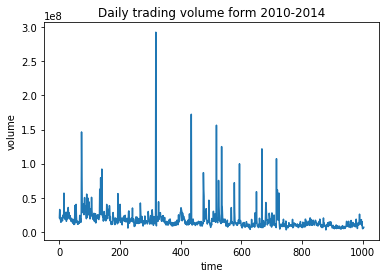

In [7]:
gild = pd.read_csv('data/gild.csv')
plt.plot(gild.iloc[:,6])
plt.title('Daily trading volume form 2010-2014')
plt.ylabel('volume')
plt.xlabel('time')
plt.show()

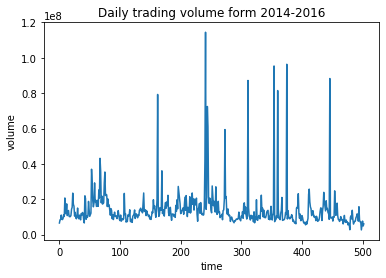

In [8]:
gild_pred = pd.read_csv('data/gild_pred.csv')
plt.plot(gild_pred.iloc[:,6])
plt.title('Daily trading volume form 2014-2016')
plt.ylabel('volume')
plt.xlabel('time')
plt.show()

## 4. Model Implementation

This project focuses on Distributed Computing Technology in order to implement the RRCF algorithm. This project primarily reads data from Google Storage Buckets on Google Cloud Platform. Google Storage was chosen and used for its consistency. The upload operations to Google Storage are atomic and thus providing strong read-after-write consistency for all upload operations. For analysis purposes, PySpark is used for its processing power while utilizing the computing power of Google Virtual Machine Clusters. As the framework of PySpark is built on top of Haddop Distributed File System, its application mechanism works on distributed data process, sending out data batches to separate worder nodes for processing. Whilst the main algorithm is tested data that is read from Google Storage Bucket, I have also included a test where I used ```sc.textFileStream``` from HDFS FileSystem to test compatibility of the main RRCF algorithm and DStreams. 

Since Resilient Distributed Dataset (RDD) was the primary API, it is discovered that there is no explicit MapReduce operations that would update the RRCF algorithm directly when filling the Forest and modifying the Trees. However, since the RDD operations are distributed across the cluster and executed in parallel without eager exection, it reduced the time for processing the RRCF algorithm.

This is an example of the execution on the Master Node of the Virtual Machine cluster. 
<img src="figs/run.png" width = 1000>

###### 4.1 AIG closing stock prices

We investigate the workings of the algorithm with histrical AIG stock prices during the period 2000-2015. No artificial anomalies are injected into the original data. We aim to examine how the model determined anomalies against our known knowledge of historical financial market anomalies. In order to create a **shinges** for the time series data, we have to manually define a function to transform our RDD into sliding windows. We define for the Forest to have 40 Trees of size 260. The sliding window is determed to be 5-days as this is the number of trading days in a week. The RRCF algorithm would them update each Tree in the Forest with each $5 \times 6$ dimensional point: 

1. For each Tree in the Forest, check if the capacity have been reached. If so, using First In First Out priciple we remove the "oldest" point in the current tree.
2. Insert the point into the current Tree.
3. Calculate the average codisplacement by updating the running average of collustive displacement inside the Forest. 

<img src="figs/avg.png" width = 500>

After observing the closing prices in the original dataset, we set the average collusive displacement threshold to be 70. The key value pairs below are (index, CoDisp value):

```(312, 86),
 (313, 80),
 (315, 77),
 (518, 72),
 (770, 104),
 (771, 81),
 (1197, 123),
 (1198, 113),
 (1199, 108),
 (1200, 101),
 (1202, 73),
 (2033, 89),
 (2034, 96),
 (2035, 87),
 (2097, 93),
 (2098, 100),
 (2099, 116),
 (2100, 95),
 (2101, 114),
 (2157, 75),
 (2182, 97),
 (2183, 143),
 (2184, 144),
 (2185, 135),
 (2186, 155),
 (2187, 122),
 (2188, 126),
 (2189, 72),
 (2407, 79),
 (2858, 155),
 (2859, 122),
 (2860, 78),
 (2861, 109),
 (2862, 103),
 (3185, 79)``` 


We plot the results against the closing prices over the 15 years. 
<img src="figs/aig.png" width = 500>

If we look at the index with the highest anomaly score, it is at 2186 with an average collustive displacement score of 155. This anomaly occurs in the week of the collapse of the insurer.

<blockquote>AIG came under attack last week as investors grew increasingly concerned about the company's capital levels. Over the weekend, it turned to the Federal Reserve for a loan, but officials had their hands full with Lehman Brothers' unraveling. Reluctant to help AIG, officials pushed investment banks to provide the funding, even as AIG's stock price fell 69% in two days.</blockquote>

(Taken from CNN Money: 2009-09-17, https://money.cnn.com/2008/09/17/news/companies/aig_explainer/index.htm)

###### 4.2 GILD daily trading volume with simulated anomalies

Similarly for Gilead Sciences daily trading volume from 2010 to 2016 we carry out the same algorithm and procedure. 16 artificial anomalies are injected into the original data and shingling is used. We define for the Forest to have 40 Trees of size 260. The sliding window is determed to be 5-days as this is the number of trading days in a week. The RRCF algorithm would them update each Tree in the Forest with each $5 \times 6$ dimensional point.

For the training dataset the threshold of the average collusive displacement score is chosen to optimize the precision and recall metrics. From there we carry out the algorithm with testing dataset at the threshold.


We plot the results against the trading volume over the 4 years. 
<img src="figs/gild.png" width = 500>

## 5. Model Evaluation
###### Precision and Recall

For the specific dataset we say that a segment is identified as an anomaly if the algorithm produces a score over the learned threshold anytime during the sliding window. That is, we include $\pm2$ of the index of the given to be considered in an anomalous state. 

We use precision and recall metrics to quantitatively evaluate our results. For this it is determined the threshold would be above 10 for the point/window of points to be considered anomalous.

The following is the confusion matrix for our results:

|        |          | Predicted |          |
|--------|----------|:---------:|----------|
|        |          | Negative  | Positive |
| **Actual** | Negative | 433       | 21       |
|        | Positive | 2         | 9        |

This results in a precision of 0.3 and recall of 0.81. The significantly low precision compare to recall is due to the positive class (anomaly calss) being the minority class. When the positive class is the minority, in our case there are only 8 anomlies artifically injected into the test set of size 503 because we are simulating the rare occasion of insider trading, even a relatively small False Positive Rate will end up causing a high number of False Posotives. Therefore the the False Positives overwhelmed the True Positives as the number of non-anomalous points is much larger.

## 6. Conclusion

We successfully implemented the Robust Random Cut Forest algorithm on Google Cloud Platform Virtual Machines using PySpark. By selecting two U.S. stocks we perform the procedure on to test the performance of the algorithm against (1) historical market events/anomalies that we have knowledge of (2) simulated scenario of insider trading on the two data sets created respectively. 

We conducted anomaly detection using the RRCF algorithm on the stock prices of the American insurer AIG in the years from 2000 to 2015. We discovered that by shingling, which is using a sliding window on the time series data as our input data stream, the algorithm was successful in capturing dips in the closing prices of the stock. More specifically, at around time index 2000 to 2250 which corresponds to the 2008 financial crisis, the RRCF algorithm results in high average collusive displacement scores at each beginning of the dip and end of the dip in stock closing price. At time index 2186, the closing stock price on 11-09-2008 was labelled as an anomaly with the highest average collusive displacement score of 155. This echoes the results presented in the original paper by Guha, where the RRCF algorithm produces spikes at the beinning and the end of the anomalous period in a simulated sine wave time series, signalling the duration of the anomaly in streaming data. In the original paper, they are called **changepoints**. We can thereby conclude that in the application of Big Data Streaming, the RRCF algorithm is capable in detecting the period where the incoming high dimensional data stream is in an anomalous state efficiently when trained. 

With the GILD stock price dataset with simulated trading volume points, we formally carry out the RRCF alorithm by training with datapoints from 2010 to 2014 in order to (1) fill the Forest with data and also (2) determine the threshold for the average $CoDisp$ score. From our training data set we determine that 10 would be the threshold with scores above which would then be classified as anomalous. Due to the highly imbalancee nature of our scenario with only $4%$ of test data points labelled as anomalous, we have a results of low precision and relatively high recall values of 0.3 and 0.81. 

Furthermore, there are several hyperparameters of the RRCF algorithm that requires tuning when implemented. These are the shingle sizes (sliding time window duration) and the threshold of which the labelling of anomalous points depends on. Shingle size are too small may catch naturally varying noise in the signal and trigger false alarms; when they are too large it may increase the likelihood of missing the anomalies. Overall it requires knowledge of the domain.

## 7. Next steps: direction of further research

The successful implementation of the RRCF algorithm in PySpark holds promise for futher research on developing a user-friendly black-boxed package for Random-Forest based anomaly detection. If I were to have more time and resources, it is a possible and welcomed contribution to the Data Science community. Some preliminary ideas are to look into ways of maintaining the Forest with compliance to the Resilient Distributed Datasets and Discretized Stream data structure in Spark. As the procedures of updating the Trees and forgetting of old data-points require iterating through all dimensions in each Tree in the Forest, it is acknowledged that more efficient executions can be explored.

## References

**GIF and graphics credits**
- MFG Labs - https://medium.com/@mfg_labs/anomaly-detection-in-hostile-environment-28e4ff875621


**Published Journals**

- Guha, S., Mishra, N., Roy, G., Schrijvers, O., 2016. Robust random cut forest based anomaly detection on streams.
- Zhiguo Ding, Minrui Fei, 2013. An Anomaly Detection Approach Based on Isolation Forest Algorithm for Streaming Data using Sliding Window.
- Liu, F. T., Ting, K. M., Zhou, Z.-H., 2012. Isolation-based anomaly detection. ACM Transactions on Knowledge Discovery from Data
- M. Bartos, A. Mullapudi, & S. Troutman, 2019. rrcf: Implementation of the Robust Random Cut Forest algorithm for anomaly detection on streams, in: Journal of Open Source Software, The Open Journal, Volume 4, Number 35. 2019